INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.4 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


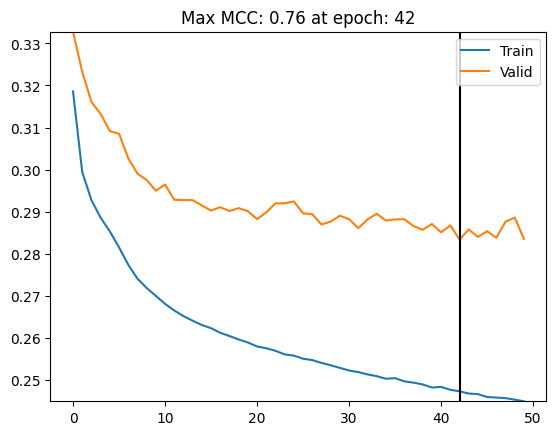

In [1]:
from helper import *

##### Create a figure
# load data

df = pd.read_csv('/home/output/loss/loss_All_but_LU_transformed.csv', sep=',')
df_m = df.groupby(['Epoch', 'Mode']).mean().reset_index()

plt.plot(df_m.loc[df_m['Mode'] == 'Train', 'Epoch'], df_m.loc[df_m['Mode'] == 'Train', 'Loss'], label='Train')
plt.plot(df_m.loc[df_m['Mode'] == 'Valid', 'Epoch'], df_m.loc[df_m['Mode'] == 'Valid', 'Loss'], label='Valid')
plt.ylim(min(df_m['Loss']), max(df_m['Loss']))

# mcc
df2 = pd.read_csv('/home/output/loss/MCC_All_but_LU_transformed.csv', sep=',')
maxMCC = df2['MCC'].max()
df2[df2['MCC']==df2['MCC'].max()]
emaxMCC = df2.loc[df2['MCC'].idxmax(), 'Epoch']

plt.title('Max MCC: ' + str(round(maxMCC, 2)) + ' at epoch: ' + str(emaxMCC))
plt.vlines(x=emaxMCC, ymin=0, ymax=.5, colors='black')
plt.legend(loc='upper right')



In [2]:
# define the model (.pth) and assess loss curves
model_name = '/home/output/models/model_state_All_but_LU_transformed_42.pth'
model_name_short = model_name.split('/')[-1].split('.')[0]
local_rank = 0
# torch.cuda.set_device(local_rank)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(0)

NClasses = 1
nf = 96
verbose = True
model_config = {'in_channels': 4,
                'spatial_size_init': (128, 128),
                'depths': [2, 2, 5, 2],
                'nfilters_init': nf,
                'nheads_start': nf // 4,
                'NClasses': NClasses,
                'verbose': verbose,
                'segm_act': 'sigmoid'}

modeli = ptavit3d_dn(**model_config).to(device)
modeli.load_state_dict(torch.load(model_name))    

model = modeli.to(device) # Set model to gpu
model.eval()


vdata = VALIDataset()

preds = []

valid_loader = DataLoader(dataset=vdata, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

trg =  sorted(glob.glob(os.path.join('/home/ai4boundaries/sentinel2/masks/' + 'LU' + '/*.tif')))

for i, tupi in enumerate(valid_loader):
    image, label = tupi
    print(image.shape)
  
    with torch.no_grad():
        pred = model(image.cuda())
        preds.append(pred.detach().cpu().numpy())

    # store the prediction
    outDir = '/home/output/predictions/' + model_name_short
    os.makedirs(outDir, exist_ok=True)
    export_np_to_tif(preds[i][0,:,:,:], rasterio.open(trg[i]), outDir, '/' + model_name_short + '_pred_LU_' + trg[i].split('/')[-1].split('_')[1])

    # store the classified prediction
    classified = InstSegm(preds[i][0,0,:,:], preds[i][0,1,:,:],0.4,0.2)
    export_single_np_to_tif(classified,
                     rasterio.open(trg[i]),
                     outDir, '/' + model_name_short + '_pred_LU_' + trg[i].split('/')[-1].split('_')[1] + '_classified')


cuda:0
 @@@@@@@@@@@@@ Going DOWN @@@@@@@@@@@@@@@@@@@ 
depth:= 0, layer_dim_in: 96, layer_dim: 96, stage_depth::2, spatial_size::(32, 32), scales::[16, 8, 8]
depth:= 1, layer_dim_in: 96, layer_dim: 192, stage_depth::2, spatial_size::(16, 16), scales::[32, 4, 4]
depth:= 2, layer_dim_in: 192, layer_dim: 384, stage_depth::5, spatial_size::(8, 8), scales::[64, 2, 2]
depth:= 3, layer_dim_in: 384, layer_dim: 768, stage_depth::2, spatial_size::(4, 4), scales::[128, 1, 1]
 XXXXXXXXXXXXXXXXXXXXX Coming up XXXXXXXXXXXXXXXXXXXXXXXXX 
depth:= 4, layer_dim_in: 384, layer_dim: 384, stage_depth::5, spatial_size::(8, 8), scales::[64, 2, 2]
depth:= 5, layer_dim_in: 192, layer_dim: 192, stage_depth::2, spatial_size::(16, 16), scales::[32, 4, 4]
depth:= 6, layer_dim_in: 96, layer_dim: 96, stage_depth::2, spatial_size::(32, 32), scales::[16, 8, 8]
torch.Size([1, 4, 6, 256, 256])
torch.Size([1, 4, 6, 256, 256])
torch.Size([1, 4, 6, 256, 256])
torch.Size([1, 4, 6, 256, 256])
torch.Size([1, 4, 6, 256, 256])
t

In [ ]:
print(len(classified.shape))
